# Clustering, cleaned notebook

### Importing libraries

In [1]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns

from scipy.spatial.distance import pdist, squareform

# import dataset
df_original_copy = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True)
df = pd.read_csv("dataset (missing + split)/train.csv", skipinitialspace=True) #this will be modified

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

### Data transformation

In [3]:
#Changing udm to duration_ms and features_duration_ms from ms to min
df['duration_ms'] *= 1/6e4
#Setting popularity as a %
df['popularity'] /= 100
df.rename(columns = {'duration_ms':'duration_min'}, inplace = True)
df.rename(columns = {'popularity':'popularity_percent'}, inplace = True)

In [4]:
#Creating genre map -> mapping every genre into an int value in order to have correlation values. 
#Redoing Pearson correlation adding genre category
df['genre'].value_counts()
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
df.replace({'genre':genre_map}).corr(numeric_only=True).style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1) #!!!

,duration_min,explicit,popularity_percent,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
duration_min,1.000000,-0.048723,-0.076202,-0.080932,0.102996,0.016712,0.039403,-0.023310,-0.074774,-0.184902,0.079685,-0.021184,-0.141938,0.048765,0.999918,0.009033,0.839313,0.838041,-0.005830,-0.010400,0.030701
explicit,-0.048723,1.000000,-0.013096,0.056992,0.124405,-0.000991,0.131777,-0.042846,0.294287,-0.113975,-0.125101,0.006995,0.008631,0.016972,-0.048699,0.051260,-0.039830,-0.039435,0.029119,-0.005878,-0.031463
popularity_percent,-0.076202,-0.013096,1.000000,0.051046,-0.056547,-0.008992,0.046703,0.073043,-0.096382,0.078424,-0.266843,0.027105,0.077652,-0.024162,-0.076228,-0.003160,-0.084774,-0.089134,-0.003665,0.008733,0.035557
danceability,-0.080932,0.056992,0.051046,1.000000,0.193940,0.035311,0.385244,-0.072422,0.111454,-0.199082,-0.202316,-0.174193,0.559578,0.092267,-0.080891,0.292167,-0.033604,-0.069332,0.011602,-0.026273,-0.125284
energy,0.102996,0.124405,-0.056547,0.193940,1.000000,0.057815,0.720907,-0.079969,0.143454,-0.699454,-0.203111,0.191024,0.284069,0.331538,0.102985,0.204646,0.243586,0.208615,0.040022,-0.037847,0.236734
key,0.016712,-0.000991,-0.008992,0.035311,0.057815,1.000000,0.047718,-0.157515,0.018157,-0.049867,-0.001532,-0.007420,0.028221,0.022414,0.016786,0.028388,0.027133,0.022042,0.019790,-0.490366,0.018896
loudness,0.039403,0.131777,0.046703,0.385244,0.720907,0.047718,1.000000,-0.033544,0.109793,-0.552519,-0.447106,0.047502,0.377743,0.308203,0.039415,0.250568,0.165565,0.131064,0.049174,-0.020563,0.119055
mode,-0.023310,-0.042846,0.073043,-0.072422,-0.079969,-0.157515,-0.033544,1.000000,-0.064289,0.085246,-0.080035,0.015738,-0.006907,-0.013001,-0.023409,-0.019378,-0.030685,-0.027687,0.003698,0.261129,0.056051
speechiness,-0.074774,0.294287,-0.096382,0.111454,0.143454,0.018157,0.109793,-0.064289,1.000000,-0.087997,-0.115803,0.050034,0.056068,0.062161,-0.074722,0.080739,-0.043217,-0.040820,0.026399,-0.022909,-0.118012
acousticness,-0.184902,-0.113975,0.078424,-0.199082,-0.699454,-0.049867,-0.552519,0.085246,-0.087997,1.000000,0.094256,-0.075924,-0.131961,-0.244244,-0.184846,-0.139706,-0.283324,-0.248164,-0.021155,0.022684,-0.196470


## Clustering searching for genre division 
I want to cluster considering only 'musical features', that are the 'technical' ones. The idea is to find the already-given division by genre.  
It is interesting, in case this works, to do a **hierarchical clustering** in order to search for 'base' genres and subgenres. 

The interesting features for the scope could be:
- `duration_min`
- `key` (categorical); 
- `mode` (categorical);
- `speechiness`;
- `acousticness`;
- `instrumentalness`;
- `tempo`;
- `time_signature` (categorical);
- `n_beats`;
- `n_bars`;  
being the latter two highly correlated with `duration_ms`, just the former is necessary. 
also `genre` in order to check the results.  
Being those the interesting attributes, a goal-specific data understanding will be done only on this data. 

Because K-means algorithm works only with continuous attributes, also a data subset with the following attributes is created and used:
- `duration_min`
- `popularity`;
- `danceability`;
- `energy`; 
- `loudness`; (trying to eliminate bc of strong correlation to `energy`)
- `speechiness`;
- `acousticness`;
- `instrumentalness`;
- `liveness`;
- `valence`;
- `tempo`.

### Outlier criterion
The outlier criterion for the following scope is composed by the following cut:
- `time_sigmature` > 1.0, in order to select only _music tracks_, where the features taken into spot are all well-defined;
- the first criterion ideally is enough but `sleep` tracks containing noise sounds often are bad-detected by the algorithm. Bc of that, in this first phase the `sleep` tracks are all excluded.  

The dataset will be tried at first without outliers [], after that, outliers will be reintroduced and clustering redone [].

### Filling `NaN` values

In [5]:
#Dealing with mode attribute missing values
#Computing p0 and p1 and filling missing values of mode attribute by sampling
#df['mode'].value_counts().plot(kind='bar', title='mode')
p0=df['mode'].value_counts()[0]/(len(df)-df['mode'].isnull().sum())
p1=df['mode'].value_counts()[1]/(len(df)-df['mode'].isnull().sum())
#print(f'p0={p0} , p1={p1}')
list_of_nan_indexes=df[df['mode'].isnull()].index.tolist()
for i in list_of_nan_indexes:
    #df.loc[i,'mode']
    #df.loc[['viper', 'sidewinder'], ['shield']] = 50
    if np.random.random() < p1:
        df.loc[i,'mode'] = 1.0
    else:
        df.loc[i,'mode'] = 0.0

In [6]:
#Dealing with time_signature attribute missing values
#Computing the array containing the probabilities of every outcome for time_signature
outcomes_of_time_signature = len(df['time_signature'].value_counts())
p_array=np.array(df['time_signature'].value_counts().sort_index(ascending=True)/(len(df)-df['time_signature'].isnull().sum()))
print(p_array)
#creating a dictionary containing the correspondance between value and sorted index
dict_ts = {0: 0.0, 1: 1.0, 2: 3.0, 3 : 4.0, 4 : 5.0}
list_of_nan_indexes_ts=df[df['time_signature'].isnull()].index.tolist()
#print(list_of_nan_indexes)
print(len(list_of_nan_indexes_ts))
from scipy.stats import multinomial 
#please forgive the dunb programming here, no real deal of time, only ~3000 points to be evaluated
for i in list_of_nan_indexes_ts:
    tmp = multinomial.rvs(1, p_array, size=1, random_state=None)
    array_tmp=np.where(tmp[0][:]==1)
    index=array_tmp[0][0] #implement a dict for the substitution
    df.loc[i,'time_signature'] = dict_ts[index]

[0.00711084 0.01151646 0.08981295 0.86257536 0.02898439]
2062


In [7]:
#Deleting outliers
df = df[(df['time_signature'] >1) & (df['genre'].str.contains('sleep')==False)]
df

,name,duration_min,explicit,popularity_percent,artists,album_name,danceability,energy,key,loudness,...,liveness,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre
0,Long Road,4.029333,False,0.46,Funki Porcini,Hed Phone Sex,0.690,0.513,5,-12.529,...,0.2810,0.6350,142.221,241760,4.0,567.0,141.0,NaN,1.279305,j-dance
1,"Daniâl My Son, Where Did You Vanish?",7.400000,False,0.00,Siavash Amini,A Trail of Laughters,0.069,0.196,1,-24.801,...,0.3600,0.0336,75.596,444000,4.0,617.0,155.0,NaN,2.367412,iranian
2,Ondskapens Galakse,5.558433,False,0.03,Kvelertak,Nattesferd,0.363,0.854,2,-7.445,...,0.2620,0.4890,116.628,333507,4.0,652.0,162.0,NaN,3.700483,black-metal
3,Can't Look Away,4.496667,False,0.23,The Wood Brothers,One Drop of Truth,0.523,0.585,5,-5.607,...,0.1170,0.3850,140.880,269800,4.0,619.0,155.0,0.469,1.279305,bluegrass
4,Thunderground,5.127517,False,0.25,The Darkraver;DJ Vince,Happy Hardcore Top 100,0.643,0.687,7,-11.340,...,0.2990,0.6370,143.956,307652,4.0,733.0,183.0,NaN,4.067086,happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,アンダスタンディング,3.750700,False,0.16,PASSEPIED,ニュイ,0.570,0.875,1,-5.065,...,0.3390,0.8020,175.017,225043,4.0,641.0,159.0,NaN,2.367412,j-idol
14995,Outpt,7.200433,False,0.00,Autechre,EP7,0.554,0.657,1,-14.232,...,0.1320,0.0335,117.319,432027,4.0,837.0,212.0,NaN,2.367412,idm
14997,Psychological Attack,6.668183,False,0.43,Droplex,Psychological Attack,0.799,0.535,1,-9.103,...,0.0713,0.0708,126.000,400091,4.0,837.0,209.0,NaN,2.367412,techno
14998,Don't Hate The 808 (feat. Lafa Taylor),3.287500,False,0.37,Bassnectar;Lafa Taylor,Noise vs Beauty,0.511,0.970,5,-2.299,...,0.4020,0.2700,160.044,197250,4.0,513.0,130.0,NaN,1.279305,breakbeat


In [8]:
#Selecting only the specific columns for the dataset
df_cont_plus_cat=df[['duration_min','key', 'mode','danceability','energy','speechiness','acousticness','instrumentalness','tempo','time_signature','genre']]
df_cont=df[['duration_min','popularity_percent', 'danceability','energy','speechiness','acousticness','instrumentalness','liveness','valence','tempo']]

In [10]:
df_cont_plus_cat.head()

,duration_min,key,mode,danceability,energy,speechiness,acousticness,instrumentalness,tempo,time_signature,genre
0,4.029333,5,1.0,0.690,0.513,0.0975,0.302000,0.53600,142.221,4.0,j-dance
1,7.400000,1,0.0,0.069,0.196,0.0805,0.283000,0.93400,75.596,4.0,iranian
2,5.558433,2,1.0,0.363,0.854,0.0397,0.000089,0.80000,116.628,4.0,black-metal
3,4.496667,5,1.0,0.523,0.585,0.0765,0.066400,0.00127,140.880,4.0,bluegrass
4,5.127517,7,1.0,0.643,0.687,0.0539,0.000576,0.09690,143.956,4.0,happy


### Measure definition
Being some of those attributes _categorical_, such as `time_signature`, it is necessary to define a custom distance, that encorporates the Euclidean distance for continuous attributes and the dissimilarity concept of distance for categorical attributes.

In [11]:
#Reindexing columns just for defining in an easier manner the custom metric
column_names_cont_and_cat = ['genre','key','duration_min', 'danceability','energy','speechiness', 'acousticness',
       'instrumentalness','tempo','mode','time_signature']


df_cont_plus_cat = df_cont_plus_cat.reindex(columns=column_names_cont_and_cat)
df_cont_plus_cat.columns

Index(['genre', 'key', 'duration_min', 'danceability', 'energy', 'speechiness',
       'acousticness', 'instrumentalness', 'tempo', 'mode', 'time_signature'],
      dtype='object')

In [12]:
df_cont_plus_cat.head()

,genre,key,duration_min,danceability,energy,speechiness,acousticness,instrumentalness,tempo,mode,time_signature
0,j-dance,5,4.029333,0.690,0.513,0.0975,0.302000,0.53600,142.221,1.0,4.0
1,iranian,1,7.400000,0.069,0.196,0.0805,0.283000,0.93400,75.596,0.0,4.0
2,black-metal,2,5.558433,0.363,0.854,0.0397,0.000089,0.80000,116.628,1.0,4.0
3,bluegrass,5,4.496667,0.523,0.585,0.0765,0.066400,0.00127,140.880,1.0,4.0
4,happy,7,5.127517,0.643,0.687,0.0539,0.000576,0.09690,143.956,1.0,4.0


In [13]:
from scipy.spatial.distance import seuclidean, jaccard
# Defining the metric
# key has a custom metric due to its circular shape 
# When the attribute is continuous, then the euclidean measure is used,
# when the attribute is categorical, dissimilarity is computed. 

def custom_dist_key(x1, x2):
    index_key = 0
    index_con = 9
    
    c = 0.09090909
    #print("x1 key", x1[index_key])
    #print("x2 key", x2[index_key])
    diff = abs(x1[index_key] - x2[index_key]) / c
    diff_key = (min(12 - diff, diff) * c)
    
    #print("diff key", diff_key)
    
    d_con = seuclidean(x1[index_key+1:index_con], x2[index_key+1:index_con], V=np.ones(index_con - 1))
    d_cat = jaccard(x1[index_con:], x2[index_con:])
    
    #print("x1 con", x1[index_key+1:index_con])
    #print("x2 con", x2[index_key+1:index_con])
    #print("d_con", d_con)
    
    #print("x1 cat", x1[index_con:])
    #print("x2 cat", x2[index_con:])
    #print("d_cat", d_cat)
    
    return diff_key + d_con + d_cat

In [15]:
# Defining the metric
# When the attribute is continuous, then the euclidean measure is used,
# when the attribute is categorical, dissimilarity is computed. key is categorical not ordinal

def custom_dist_cat_and_cont(x1, x2):
    index_key = 0
    index_con = 9
    indexes=np.array([0,9,10])
    cat1=np.take(x1,indexes)
    cat2=np.take(x2,indexes)
    
    d_con = seuclidean(x1[index_key+1:index_con], x2[index_key+1:index_con], V=np.ones(index_con - 1))
    
    d_cat = jaccard(cat1, cat2)
    
    #print("x1 con", x1[index_key+1:index_con])
    #print("x2 con", x2[index_key+1:index_con])
    #print("d_con", d_con)
    
    #print("x1 cat", cat1)
    #print("x2 cat", cat2)
    #print("d_cat", d_cat)
    
    return d_con + d_cat

### Normalization (or, standardization)
It is necessary to choose a type of normalization. Looking at the distributions of the attributes for the scope, it is possible to decide with some criteria, see: https://developers.google.com/machine-learning/data-prep/transform/normalization?hl=en .

In [16]:
genre_map={"j-dance":0,"iranian":1,"brazil":2,"chicago-house":3,"forro":4,"idm":5,"indian":6,"study":7,"disney":8,"afrobeat":9,"mandopop":10,"techno":11,"sleep":12,"spanish":13,"j-idol":14,"industrial":15,"happy":16,"bluegrass":17,"black-metal":18,"breakbeat":19}
df_cont_plus_cat.replace({'genre':genre_map})
X_cont_and_cat = df_cont_plus_cat.replace({'genre':genre_map}).values #key is included
X_cont = df_cont.replace({'genre':genre_map}).values #only continuous values
y = np.array(df['genre'])
y_mapped = pd.DataFrame(y).iloc[:,0]

In [17]:
#performing minmax normalization 
scaler = MinMaxScaler()
X_minmax_cont_and_cat = scaler.fit_transform(X_cont_and_cat)
X_minmax_cont = scaler.fit_transform(X_cont)
#Now we have the two dataset and the metrics!

# Distance matrices computation

In [18]:
#computing the distance matrices - euclidean
dist_std = pdist(X_minmax_cont, 'euclidean')
dist_std = squareform(dist_std)


In [19]:
#computing the distance matrices - continuous + categorical with custom distance on key
D_key = pdist(X_minmax_cont_and_cat, custom_dist_key)
D_key = squareform(D_key)

In [73]:
D_key

array([[0.        , 1.53854471, 0.851252  , ..., 1.10606206, 0.88926803,
        0.9549932 ],
       [1.53854471, 0.        , 1.52761909, ..., 1.97289027, 2.09982524,
        2.05395227],
       [0.851252  , 1.52761909, 0.        , ..., 0.95108838, 0.95234284,
        1.57455533],
       ...,
       [1.10606206, 1.97289027, 0.95108838, ..., 0.        , 1.51282063,
        1.36779846],
       [0.88926803, 2.09982524, 0.95234284, ..., 1.51282063, 0.        ,
        1.18443633],
       [0.9549932 , 2.05395227, 1.57455533, ..., 1.36779846, 1.18443633,
        0.        ]])

In [20]:
#computing the distance matrices - continuous + categorical with std distance on key
D_cat = pdist(X_minmax_cont_and_cat, custom_dist_cat_and_cont)
D_cat = squareform(D_cat)

KeyboardInterrupt: 

## Internal measures for cluster validation
In addition to the SSE and Sil coefficient, a metric validated by the following article: https://pubmed.ncbi.nlm.nih.gov/23193245/
has been used, implemented by the authors of a linked repository (see below).
### CVNN index implementation
All right deserved to the authors of the following GitHub repository: https://github.com/clslabMSU/clustGUI/tree/master 

In [254]:
# all rights to the following repository authors: https://github.com/clslabMSU/clustGUI/tree/master 
"""
Created on Sun Apr 23 16:15:37 2017

"""
import numpy as np

import scipy as sy
from math import pow 

class internalIndex:
    def  __init__(self, num_k):
        self.num_k = num_k
        self.class_iter = range(1, num_k +1)
    
    def euclidean_centroid(self, data,label, label_num = False):
        if label_num == False:
            num_attr = data.shape[1]
            centroid = np.zeros([1, num_attr])
            for attr_id in range(num_attr):
                sum_attr_id = 0
                for i in range(len(data)):
                    sum_attr_id += data[i][attr_id]
                centroid[0][attr_id] = sum_attr_id/len(data)
            return centroid[0]
        else:
            count = 0
            for l in label:
                if l == label_num:
                    count +=1
            length = count
            num_attr = data.shape[1]
            centroid = np.zeros([1, num_attr])
            for attr_id in range(num_attr):
                sum_attr_id = 0
                for i in range(len(data)):
                    if label[i] == label_num:
                        sum_attr_id += data[i][attr_id]
                centroid[0][attr_id] = sum_attr_id/length
            return centroid[0]
    def centroid_list(self, data,label):
        c_list = []
        for index_i in self.class_iter:
            c_list.append(self.euclidean_centroid(data,label,index_i))
        return c_list
        
    def element_of_clustert (self, data, label, cluster_i):
        eoc = []
        for l in range(len(data)):
            if label[l] == cluster_i:
                eoc.append(data[l])
        return np.asarray(eoc)
    
    def distance_from_cluster (self, data, label,  cluster_i, centroid_i):
        eoc = self.element_of_clustert(data, label, cluster_i)
        centroid_i = self.euclidean_centroid(data, label, centroid_i)
        distance = 0
        for i in eoc:
            distance += sy.spatial.distance.euclidean(centroid_i, i)
        return distance
    
    def distance_from_cluster_sqr (self, data, label,  cluster_i, centroid_i):
        eoc = self.element_of_clustert(data, label, cluster_i)
        centroid_i = self.euclidean_centroid(data, label, centroid_i)
        distance = 0
        for i in eoc:
            distance += sy.spatial.distance.sqeuclidean(centroid_i, i)
        return distance
    
    
    def nn_exclude(self, data, label, data_i ,label_i ,k):
        data_i = [data_i]
        dist_mat = sy.spatial.distance.cdist(data_i, data)[0]
        dist_mat = np.argsort(dist_mat)[1:k+1]
        count = 0
        for i in dist_mat:
            if label_i != i:
                count = count + 1
        return count

    
    def CVNN(self, data, label, distance): #data is the array X_minmax, label are the cluster labels
        #Need COM and SEP
        k = 10
        COM = 0
        SEP = []
        for index_i in self.class_iter:
            temp_sep = 0
            eoc  = self.element_of_clustert(data, label, index_i)
            n= len(eoc)
            if n !=1:
                COM = COM + (sum(sy.spatial.distance.pdist(eoc,distance)) * 2 / (n*(n-1)))
            for e in eoc:
                q_index_e = self.nn_exclude(data, label, e, index_i, k )
                temp_sep = temp_sep +(q_index_e / k)
            SEP.append(temp_sep)
        SEP = max(SEP)
        return COM , SEP
    #SEP and COM has to be computed for all NCs in order to construct the
    def CVNN_n(self, COM, SEP): 
        index = self.num_k - 2
        return COM[index] / max(COM) + SEP[index] / max(SEP) 
        
        

It is necessary to compute the SEP and COM for every NC possible, we fix the range in [2,200].

In [255]:
idx = internalIndex(50) #The number inside fixes the number of nearest neighbors

In [258]:
cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont_and_cat,hier.labels_,'euclidean')
print(cvnn_com,cvnn_sep)

43.77424632938545 640.0


### Hierarichiacal clustering
It has to be done for the new sets:
- Set of only continuous attributes [ ]
- Set of continuous and categorical [ ]
    - 'standard' custom distance [ ]
    - 'customized' custom distance [ ]

In [23]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [24]:
# Continuous:
#     - simple [x]
#     - complete [x]
#     - Ward [x]
#     - average [x]
# Continuous + categorical - standard distance:
#     - simple [x]
#     - complete [x]
#     - average [x]
# Continuous + categorical - custom distance:
#     - simple [x]
#     - complete [x]
#     - average [x]
hier = AgglomerativeClustering(distance_threshold=None, metric='precomputed', linkage='average', compute_distances=True, compute_full_tree=False)
hier = hier.fit(D_key)

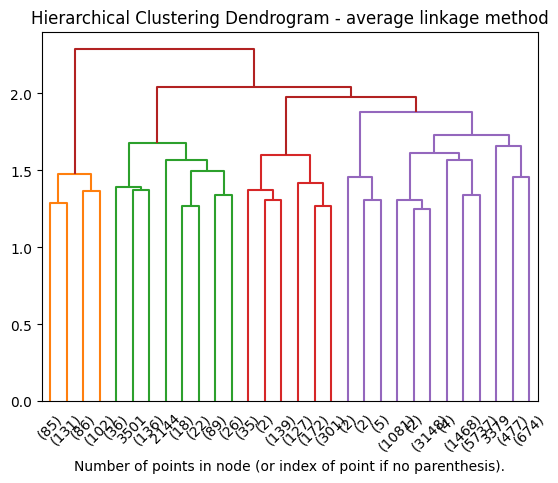

In [72]:
plt.title(f"Hierarchical Clustering Dendrogram - {hier.linkage} linkage method")
plot_dendrogram(hier, truncate_mode="lastp",color_threshold=1.9,above_threshold_color='firebrick') #set color_threshold
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [67]:
# get the labels according to a specific threshold value cut
Z = get_linkage_matrix(hier)
#Computation of Silhouette coefficient
# Continuous X_minmax_cont:
#     - simple [x]
#     - complete [x]
#     - Ward [x]
#     - average [x]
# Continuous + categorical - standard distance X_minmax_cont_and_cat:
#     - simple [x] [x]
#     - complete [x] []
#     - average [x] [x]
# Continuous + categorical - custom distance X_minmax_cont_and_cat:
#     - simple [x] [x]
#     - complete [x] []
#     - average [x] []
dist = np.linspace(2.0,0,100)
n_clu = []
sil_score_list = []
for i in dist:
    labels = fcluster(Z, t=i, criterion='distance')
    #print(max(labels))
    if max(labels)+1 > 2000:
        #print('breaking the loop')
        break
        #print('yay')
    n_clu.append(max(labels+1))
    sil_score_list.append(silhouette_score(D_key,labels,metric='precomputed'))
    print(f'distance is {i}, it correspond to {max(labels+1)} clusters, Sil = {sil_score_list[-1]}')


distance is 2.0, it correspond to 4 clusters, Sil = 0.283082336151411
distance is 1.97979797979798, it correspond to 5 clusters, Sil = 0.2754122894687085
distance is 1.9595959595959596, it correspond to 5 clusters, Sil = 0.2754122894687085
distance is 1.9393939393939394, it correspond to 5 clusters, Sil = 0.2754122894687085
distance is 1.9191919191919191, it correspond to 5 clusters, Sil = 0.2754122894687085
distance is 1.898989898989899, it correspond to 5 clusters, Sil = 0.2754122894687085
distance is 1.878787878787879, it correspond to 6 clusters, Sil = 0.23231339352402433
distance is 1.8585858585858586, it correspond to 6 clusters, Sil = 0.23231339352402433
distance is 1.8383838383838385, it correspond to 6 clusters, Sil = 0.23231339352402433
distance is 1.8181818181818181, it correspond to 6 clusters, Sil = 0.23231339352402433
distance is 1.797979797979798, it correspond to 6 clusters, Sil = 0.23231339352402433
distance is 1.7777777777777777, it correspond to 6 clusters, Sil = 0.2

0.25191897510010136 0


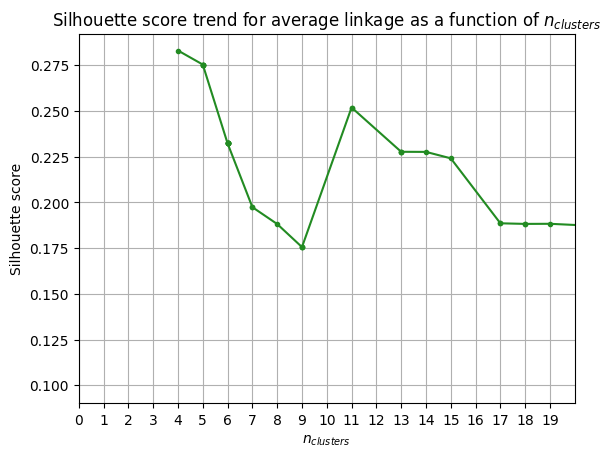

In [60]:
#Plot the silhouette score trend
plt.figure()
plt.title(fr'Silhouette score trend for {hier.linkage} linkage as a function of $n_{{clusters}}$')
plt.errorbar(n_clu,sil_score_list,marker='.',color='forestgreen')
plt.xlabel(r'$n_{clusters}$')
plt.ylabel('Silhouette score')
plt.grid()
plt.xlim(0,20)
plt.xticks(np.arange(0,20))
print(max(sil_score_list[6:]), np.array(sil_score_list).argmax())

plt.show()

In [38]:
print(sil_score_list[14])

0.19740725302608597


In [61]:
#Printing the best Sil for the routine
#Computation of Silhouette coefficient
# Continuous X_minmax_cont:
#     - single []
#     - complete []
#     - Ward []
#     - average []
# Continuous + categorical - standard distance X_minmax_cont_and_cat:
#     - single [x]
#     - complete [x]
#     - average [x]
# Continuous + categorical - custom distance X_minmax_cont_and_cat:
#     - single [x]
#     - complete [x]
#     - average []
hier = AgglomerativeClustering(distance_threshold=None, n_clusters=11, metric='precomputed', linkage='average', compute_distances=True, compute_full_tree=False)
hier = hier.fit(D_key)
max_sil=silhouette_score(D_key,hier.labels_,metric='precomputed')
print(max_sil)


0.25115130649245043


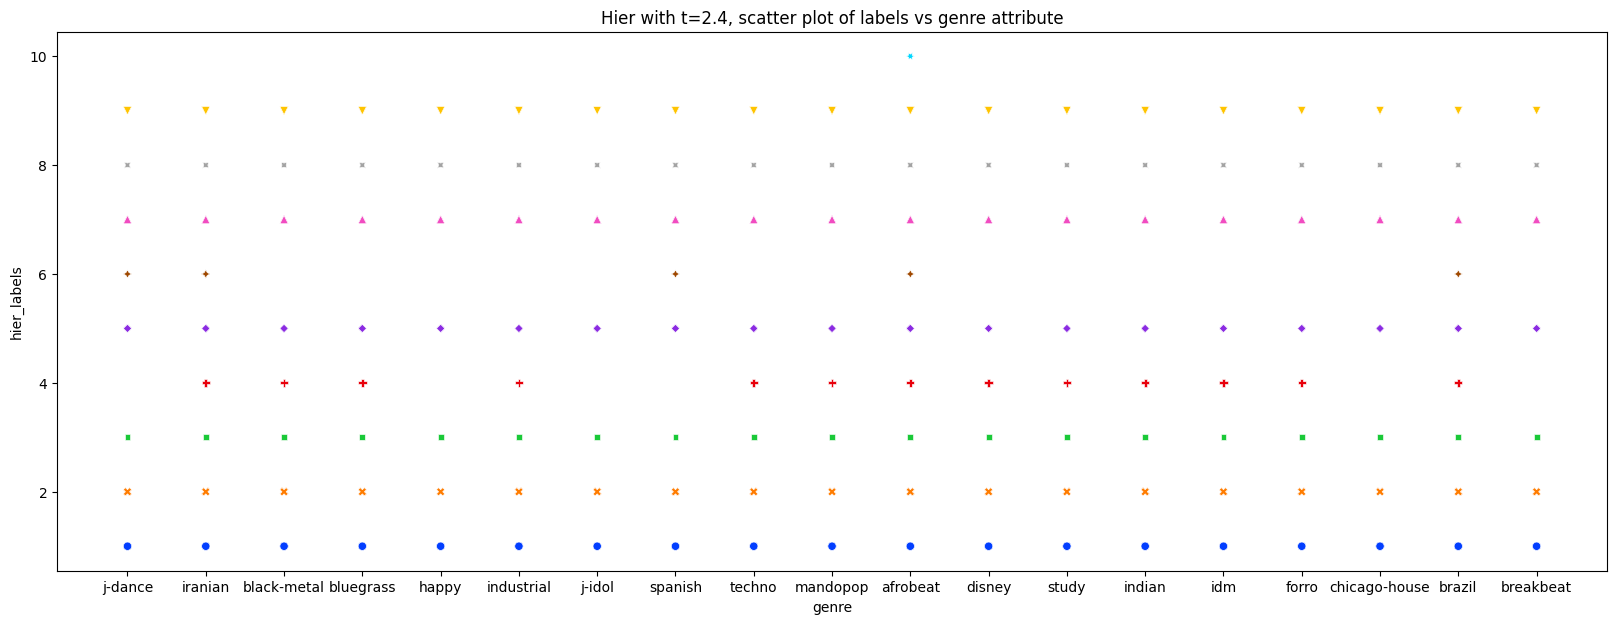

In [68]:
labels1 = fcluster(Z, t=1.6, criterion='distance')
df['hier_labels'] = labels1
plt.figure(figsize=(20,7))
plt.title('Hier with t=2.4, scatter plot of labels vs genre attribute')
sns.scatterplot(data=df, x="genre", y="hier_labels", hue=labels1, 
                style='hier_labels', palette="bright",legend=False)
plt.show()

In [71]:
df[df['hier_labels'] == 6]

,name,duration_min,explicit,popularity_percent,artists,album_name,danceability,energy,key,loudness,...,valence,tempo,features_duration_ms,time_signature,n_beats,n_bars,popularity_confidence,processing,genre,hier_labels
1405,O Que Separa os Homens dos Meninos,3.400000,True,0.53,Sant;Stau,"O Que Separa os Homens dos Meninos, Vol. 1",0.641,0.6350,9,-10.050,...,0.6600,80.483,204000,4.0,263.0,66.0,NaN,1.343558,brazil,6
1425,"Autonom III, Op. 10",4.290167,False,0.00,Alireza Mashayekhi,Happy Electronic Sounds,0.461,0.4380,5,-15.467,...,0.0659,147.657,257411,4.0,537.0,135.0,NaN,1.279305,iranian,6
2117,Nabard,1.693333,False,0.00,Alireza Mashayekhi;Djamchid Chemirani;Keyvan C...,"Mashayekhi: Sheherazade ""Layla Ramezan Plays 1...",0.556,0.0765,6,-30.873,...,0.2510,94.727,101600,3.0,157.0,52.0,NaN,1.170953,iranian,6
3764,Vivão (vinheta),1.165700,False,0.18,Afrocidade,Vivão,0.483,0.8870,0,-8.489,...,0.6130,74.325,69942,4.0,83.0,21.0,NaN,3.349057,afrobeat,6
7106,Una Nube,2.620317,False,0.43,Vuelta Canela,Juegos Canelos,0.705,0.0715,0,-23.231,...,0.7130,115.326,157219,4.0,302.0,75.0,NaN,3.349057,spanish,6
8520,V-3,0.467100,False,0.00,Leila Bela,Angra Manyu,0.612,0.1370,8,-31.953,...,0.3930,100.765,28027,4.0,43.0,10.0,NaN,2.725904,iranian,6
9527,Shekast,1.036667,False,0.00,Alireza Mashayekhi;Djamchid Chemirani;Keyvan C...,"Mashayekhi: Sheherazade ""Layla Ramezan Plays 1...",0.610,0.1310,0,-31.652,...,0.1780,130.204,62200,3.0,129.0,41.0,NaN,3.349057,iranian,6
12208,Dem Nuh Loyal,3.236800,False,0.20,6t6,Dem Nuh Loyal,0.710,0.4530,0,-14.977,...,0.6320,176.480,194208,4.0,565.0,142.0,NaN,3.349057,j-dance,6
13870,Beyond Tribes Pt. 1,32.293867,False,0.00,Zhoobin Askarieh;Ali Sasha,Beyond Tribes,0.302,0.6920,9,-15.026,...,0.1770,175.989,1937633,4.0,4979.0,1256.0,NaN,1.343558,iranian,6


In [259]:
#Computation of CVNN
# Continuous X_minmax_cont:
#     - simple []
#     - complete []
#     - Ward []
#     - average []
# Continuous + categorical - standard distance X_minmax_cont_and_cat: 
#     - simple []
#     - complete []
#     - Ward []
#     - average []
# Continuous + categorical - custom distance:
#     - simple []
#     - complete []
#     - Ward []
#     - average []
#Computation of CVNN
# Continuous
n_clusters=np.arange(2,200)
COM_list_cont_ward = []
SEP_list_cont_ward = []
for n in n_clusters:
    #ward method
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='euclidean', linkage='ward', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(X_minmax_cont)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,'euclidean')
    COM_list_cont_ward.append(cvnn_com)
    SEP_list_cont_ward.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_cont_ward = np.array(COM_list_cont_ward)
SEPS_cont_ward = np.array(SEP_list_cont_ward)
CVNN_idx= (COMS_cont_ward / np.max(COMS_cont_ward)) + (SEPS_cont_ward / np.max(SEPS_cont_ward))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [269]:
len(n_clusters)


48

Text(0, 0.5, 'CVNN index')

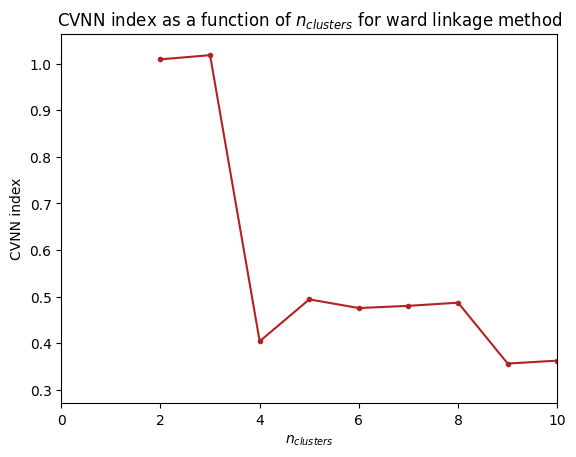

In [295]:
plt.figure()
n_clusters=np.arange(2,200)
plt.title(fr'CVNN index as a function of $n_{{clusters}}$ for ward linkage method')
plt.errorbar(n_clusters,CVNN_idx,marker='.',color='firebrick')
plt.xlabel(r'$n_{clusters}$')
plt.xlim(0,10)
plt.ylabel('CVNN index')

In [260]:
#Computation of CVNN
# Continuous
#average method
n_clusters=np.arange(2,200)
COM_list_cont_average = []
SEP_list_cont_average = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='euclidean', linkage='average', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(X_minmax_cont)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,'euclidean')
    COM_list_cont_average.append(cvnn_com)
    SEP_list_cont_average.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_cont_average = np.array(COM_list_cont_average)
SEPS_cont_average = np.array(SEP_list_cont_average)
CVNN_idx_cont_average= (COMS_cont_average / np.max(COMS_cont_average)) + (SEPS_cont_average / np.max(SEPS_cont_average))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


Text(0, 0.5, 'CVNN index')

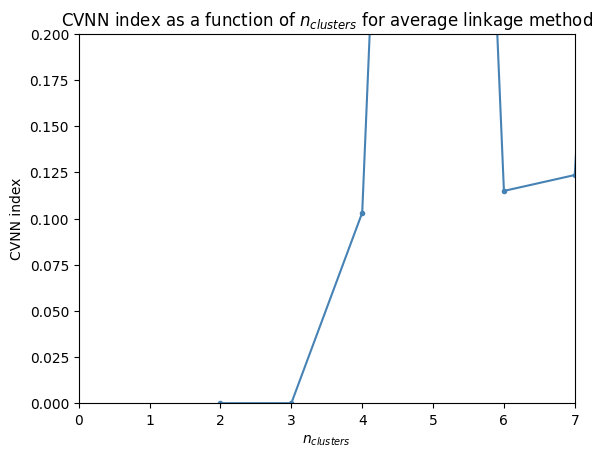

In [291]:
plt.figure()
n_clusters=np.arange(2,200)
plt.title(fr'CVNN index as a function of $n_{{clusters}}$ for average linkage method')
plt.errorbar(n_clusters,CVNN_idx_cont_average,marker='.',color='steelblue')
plt.xlabel(r'$n_{clusters}$')
plt.xlim(0,7)
plt.ylim(0,0.2)
plt.ylabel('CVNN index')

In [261]:
#Computation of CVNN
# Continuous
#complete method
n_clusters=np.arange(2,200)
COM_list_cont_complete = []
SEP_list_cont_complete = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='euclidean', linkage='complete', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(X_minmax_cont)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,'euclidean')
    COM_list_cont_complete.append(cvnn_com)
    SEP_list_cont_complete.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_cont_complete = np.array(COM_list_cont_complete)
SEPS_cont_complete = np.array(SEP_list_cont_complete)
CVNN_idx_cont_complete= (COMS_cont_complete / np.max(COMS_cont_complete)) + (SEPS_cont_complete / np.max(SEPS_cont_complete))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


Text(0, 0.5, 'CVNN index')

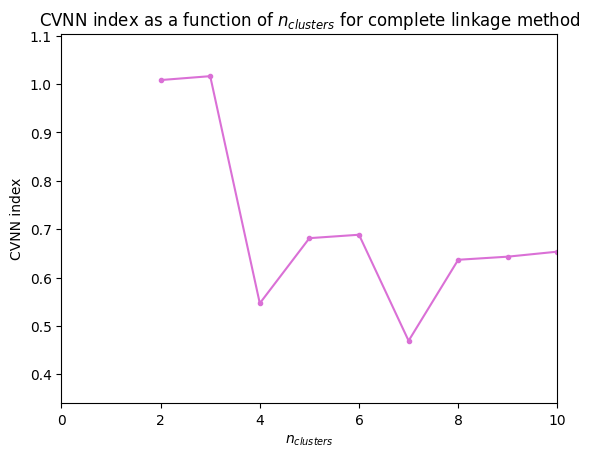

In [293]:
plt.figure()
n_clusters=np.arange(2,200)
plt.title(fr'CVNN index as a function of $n_{{clusters}}$ for complete linkage method')
plt.errorbar(n_clusters,CVNN_idx_cont_complete,marker='.',color='orchid')
plt.xlabel(r'$n_{clusters}$')
plt.xlim(0,10)
plt.ylabel('CVNN index')

In [262]:
#Computation of CVNN
# Continuous
#single method
n_clusters=np.arange(2,200)
COM_list_cont_single = []
SEP_list_cont_single = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='euclidean', linkage='single', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(X_minmax_cont)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,'euclidean')
    COM_list_cont_single.append(cvnn_com)
    SEP_list_cont_single.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_cont_single = np.array(COM_list_cont_single)
SEPS_cont_single = np.array(SEP_list_cont_single)
CVNN_idx_cont_single= (COMS_cont_single / np.max(COMS_cont_single)) + (SEPS_cont_single / np.max(SEPS_cont_single))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


Text(0, 0.5, 'CVNN index')

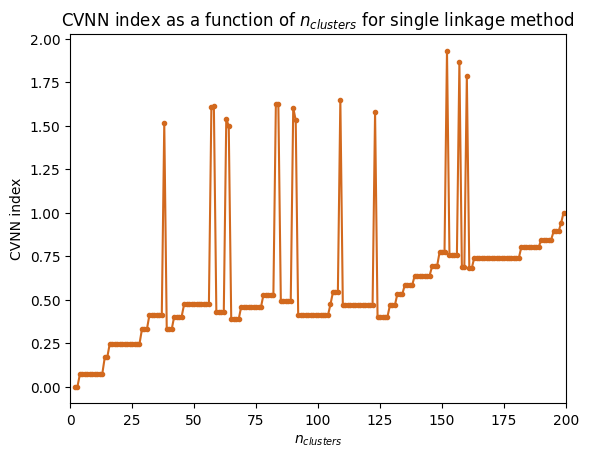

In [285]:
plt.figure()
n_clusters=np.arange(2,200)
plt.title(fr'CVNN index as a function of $n_{{clusters}}$ for single linkage method')
plt.errorbar(n_clusters,CVNN_idx_cont_single,marker='.',color='chocolate')
plt.xlabel(r'$n_{clusters}$')
plt.xlim(0,200)
plt.ylabel('CVNN index')

In [265]:
#Computation of CVNN
# Continuous + categorical, std dist
#single method
n_clusters=np.arange(2,50)
COM_list_concat_single = []
SEP_list_concat_single = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='precomputed', linkage='single', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D_cat)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,custom_dist_cat_and_cont)
    COM_list_concat_single.append(cvnn_com)
    SEP_list_concat_single.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_concat_single = np.array(COM_list_concat_single)
SEPS_concat_single = np.array(SEP_list_concat_single)
CVNN_idx_concat_single= (COMS_concat_single / np.max(COMS_concat_single)) + (SEPS_concat_single / np.max(SEPS_concat_single))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


KeyboardInterrupt: 

In [ ]:
#Computation of CVNN
# Continuous + categorical, std distance
#complete method
n_clusters=np.arange(2,50)
COM_list_concat_complete = []
SEP_list_concat_complete = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='precomputed', linkage='complete', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D_cat)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,custom_dist_cat_and_cont)
    COM_list_concat_complete.append(cvnn_com)
    SEP_list_concat_complete.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_concat_complete = np.array(COM_list_concat_complete)
SEPS_concat_complete = np.array(SEP_list_concat_complete)
CVNN_idx_concat_complete= (COMS_concat_complete / np.max(COMS_concat_complete)) + (SEPS_concat_complete / np.max(SEPS_concat_complete))

In [ ]:
#Computation of CVNN
# Continuous + categorical, std distance
#average method
n_clusters=np.arange(2,50)
COM_list_concat_average = []
SEP_list_concat_average = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='precomputed', linkage='average', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D_cat)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,custom_dist_cat_and_cont)
    COM_list_concat_average.append(cvnn_com)
    SEP_list_concat_average.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_concat_average = np.array(COM_list_concat_average)
SEPS_concat_average = np.array(SEP_list_concat_average)
CVNN_idx_concat_average= (COMS_concat_average / np.max(COMS_concat_average)) + (SEPS_concat_average / np.max(SEPS_concat_average))

In [ ]:
#Computation of CVNN
# Continuous + categorical, custom distance
#average method
n_clusters=np.arange(2,50)
COM_list_concat_cust_average = []
SEP_list_concat_cust_average = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='precomputed', linkage='average', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D_key)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,custom_dist_key)
    COM_list_concat_cust_average.append(cvnn_com)
    SEP_list_concat_cust_average.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_concat_cust_average = np.array(COM_list_concat_cust_average)
SEPS_concat_cust_average = np.array(SEP_list_concat_cust_average)
CVNN_idx_concat_cust_average= (COMS_concat_cust_average / np.max(COMS_concat_cust_average)) + (SEPS_concat_cust_average/ np.max(SEPS_concat_cust_average))

In [ ]:
#Computation of CVNN
# Continuous + categorical, custom distance
#complete method
n_clusters=np.arange(2,50)
COM_list_concat_cust_complete = []
SEP_list_concat_cust_complete = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='precomputed', linkage='complete', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D_key)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,custom_dist_key)
    COM_list_concat_cust_complete.append(cvnn_com)
    SEP_list_concat_cust_complete.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_concat_cust_complete = np.array(COM_list_concat_cust_complete)
SEPS_concat_cust_complete = np.array(SEP_list_concat_cust_complete)
CVNN_idx_concat_cust_complete= (COMS_concat_cust_complete / np.max(COMS_concat_cust_complete)) + (SEPS_concat_cust_complete/ np.max(SEPS_concat_cust_complete))

In [ ]:
#Computation of CVNN
# Continuous + categorical, custom distance
#single method
n_clusters=np.arange(2,50)
COM_list_concat_cust_single = []
SEP_list_concat_cust_single = []
for n in n_clusters:
    idx = internalIndex(n-1) #The number inside fixes the number of clusters
    print(n)
    hier = AgglomerativeClustering(distance_threshold=None, n_clusters=n, metric='precomputed', linkage='single', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D_key)
    cvnn_com,cvnn_sep=idx.CVNN(X_minmax_cont,hier.labels_,custom_dist_key)
    COM_list_concat_cust_single.append(cvnn_com)
    SEP_list_concat_cust_single.append(cvnn_sep)

# transforming lists in np arrays in order to do some operations
COMS_concat_cust_single = np.array(COM_list_concat_cust_single)
SEPS_concat_cust_single = np.array(SEP_list_concat_cust_single)
CVNN_idx_concat_cust_single= (COMS_concat_cust_single / np.max(COMS_concat_cust_single)) + (SEPS_concat_cust_single/ np.max(SEPS_concat_cust_single))

## Cluster tendency
Instead of using the SSE for cluster tendency validation, here we will use the Silhouette coefficient, being it more robust, fast computing and the one used by us for choosing the best clustering method.

In [476]:
X_minmax_cont_and_cat[:,0] # this is 0 column (all data objects)

array([0.45454545, 0.09090909, 0.18181818, ..., 0.09090909, 0.45454545,
       0.54545455])

In [21]:
N = 200
sil_stats_continuous = []

for _ in range(N):
    print(_)
    Xi = np.zeros(shape=X_minmax_cont.shape)
    
    for cidx in range(Xi.shape[1]):
        col = X_minmax_cont[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))
        
    hier = AgglomerativeClustering(distance_threshold=None, metric='euclidean', linkage='ward', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(Xi)

    sil_stats_continuous.append(silhouette_score(Xi,hier.labels_,))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [22]:
hier = AgglomerativeClustering(distance_threshold=None, metric='euclidean', linkage='ward', compute_distances=True, compute_full_tree=False)
hier = hier.fit(X_minmax_cont)

my_sil_continuous=silhouette_score(X_minmax_cont,hier.labels_)

In [23]:
print('My Sil is {}, the mean and std of the random Sils are: {} +/- {}'.format(my_sil_continuous,np.mean(sil_stats_continuous),np.std(sil_stats_continuous)))

My Sil is 0.29609479237569386, the mean and std of the random Sils are: 0.03114825924626644 +/- 0.0021048779732053967


In [37]:
from scipy.spatial.distance import seuclidean, jaccard
# Defining the metric
# key has a custom metric due to its circular shape 
# When the attribute is continuous, then the euclidean measure is used,
# when the attribute is categorical, dissimilarity is computed. 

def custom_dist_key(x1, x2):
    index_key = 0
    index_con = 8
    
    c = 0.09090909
    #print("x1 key", x1[index_key])
    #print("x2 key", x2[index_key])
    #print(12-abs(x1[index_key] - x2[index_key]) / c)
    #print(np.min(12,11))
    diff = abs(x1[index_key] - x2[index_key]) / c
    diff_key = (np.min([12 - diff, diff])) * c
    
    #print("diff key", diff_key)
    
    d_con = seuclidean(x1[index_key+1:index_con], x2[index_key+1:index_con], V=np.ones(index_con - 1))
    d_cat = jaccard(x1[index_con:], x2[index_con:])
    
    #print("x1 con", x1[index_key+1:index_con])
    #print("x2 con", x2[index_key+1:index_con])
    #print("d_con", d_con)
    
    #print("x1 cat", x1[index_con:])
    #print("x2 cat", x2[index_con:])
    #print("d_cat", d_cat)
    
    return diff_key + d_con + d_cat

In [36]:
np.min([3,4])

3

In [40]:
#Computing Sil for random data - custom distance
# average []
# complete []
N = 1
sil_stats = []

for _ in range(N):
    print(_)
    Xi = np.zeros(shape=X_minmax_cont_and_cat.shape)
    # problem here is that we cannot sample in this way categorical values!
    #we have to select the right indexes and for them sampling random from the right ensemble
    #separating categorical, continuous and key
    index_key = 0
    index_con = np.array([1,2,3,4,5,6,7])
    index_cat = np.array([8,9])
    
    #sampling randomly the key
    col = X_minmax_cont_and_cat[:, 0]
    nor = len(col)
    Xi[:, 0] = np.random.choice(np.unique(X_minmax_cont_and_cat[:,0]), size=(1, nor))
    #sampling randomly continuous values
    for cidx in index_con:
        col = X_minmax_cont[:, cidx]
        min1, max1, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min1, max1, (1, nor))
    #sampling randomly from categorical values
    for cidx in index_cat:
        col = X_minmax_cont_and_cat[:, cidx]
        nor = len(col)
        Xi[:, cidx] = np.random.choice(np.unique(X_minmax_cont_and_cat[:,cidx]), size=(1, nor))
    #print(Xi)
    #print(Xi[0,0])
        
    D = pdist(Xi, custom_dist_key)
    D = squareform(D)
    hier = AgglomerativeClustering(distance_threshold=None, metric='precomputed', linkage='average', compute_distances=True, compute_full_tree=False)
    hier = hier.fit(D)
    
    sil_stats.append(silhouette_score(D_key,hier.labels_,metric='precomputed'))

0


In [ ]:
hier = AgglomerativeClustering(distance_threshold=None, metric='precomputed', linkage='average', compute_distances=True, compute_full_tree=False)
hier = hier.fit(X_minmax_cont)

my_sil_continuous=silhouette_score(X_minmax_cont,hier.labels_)

In [468]:
print('My Sil is {}, the mean and std of the random Sils are: {}'.format(my_sil,np.mean(sil_stats)))

My Sil is 0.3731604763382851, the mean and std of the random Sils are: 0.3731604763382851 +/- 0.0


# DBSCAN

### First subset - Euclidean distance

In [420]:
###Troviamo Eps
k=10
kth_distances_std = []
for d in dist_std:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance_std = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances_std.append(d[index_kth_distance_std])  # store the distance in a list

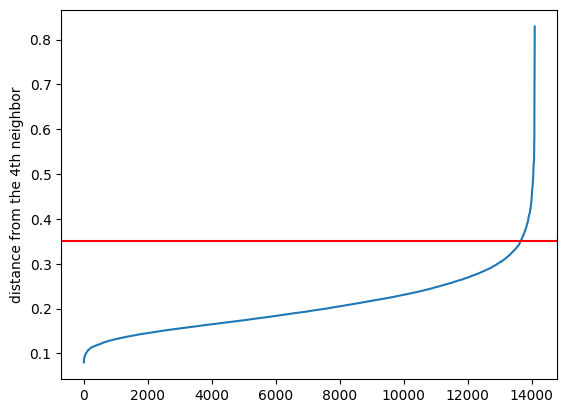

In [421]:
#Plot per la scelta di Eps
plt.plot(range(0, len(kth_distances_std)), sorted(kth_distances_std))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.axhline(y=0.35, color='r', linestyle='-')
         
plt.show()

In [461]:
dbscan = DBSCAN(eps=0.35, min_samples=5, metric='precomputed')
dbscan.fit(dist_std)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(X_minmax_cont, dbscan.labels_))
plt.show()

labels {-1: 196, 0: 13892, 1: 0}
silhouette 0.1776574070526235


In [378]:
nn_min=np.arange(2,51)
sil_list=[]
for i in nn_min:
    print(i)
    dbscan = DBSCAN(eps=0.3, min_samples=i, metric='precomputed')
    dbscan.fit(dist_std)
    sil_list.append(silhouette_score(X_minmax_cont, dbscan.labels_))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


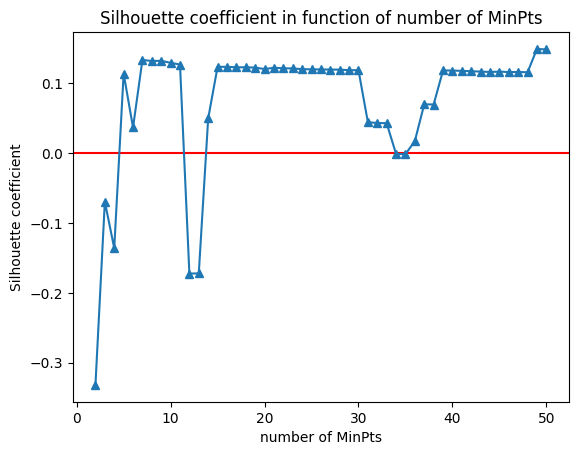

In [387]:
plt.figure()
plt.title('Silhouette coefficient in function of number of MinPts')
plt.errorbar(nn_min, sil_list, marker='^')
plt.axhline(y=0., color='r', linestyle='-')
plt.ylabel('Silhouette coefficient')
plt.xlabel(r'number of MinPts')
plt.show()

### Second subset - custom key distance

In [76]:
###Troviamo Eps
k=10
kth_distances_std = []
for d in D_key:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance_std = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances_std.append(d[index_kth_distance_std])  # store the distance in a list

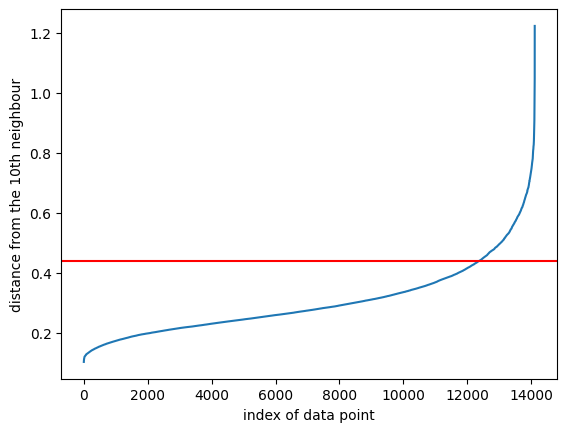

In [77]:
#Plot per la scelta di Eps
plt.plot(range(0, len(kth_distances_std)), sorted(kth_distances_std))
plt.ylabel('distance from the {}th neighbour'.format(k))
plt.xlabel('index of data point')
plt.axhline(y=0.44, color='r', linestyle='-')
         
plt.show()

In [78]:
#for loop per il calcolo di MinPts
nn_min=np.arange(2,51)
sil_list=[]
for i in nn_min:
    print(i)
    dbscan = DBSCAN(eps=0.44, min_samples=i, metric='precomputed')
    dbscan.fit(D_key)
    sil_list.append(silhouette_score(D_key,dbscan.labels_,metric='precomputed'))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


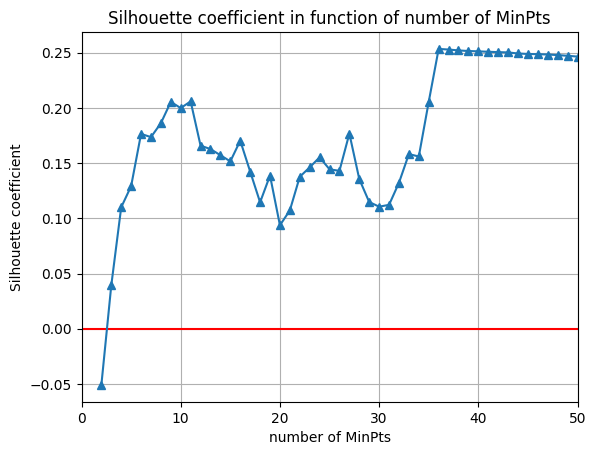

In [80]:
# plot per la scelta dei MinPts
plt.figure()
plt.title('Silhouette coefficient in function of number of MinPts')
plt.errorbar(nn_min, sil_list, marker='^')
plt.axhline(y=0., color='r', linestyle='-')
plt.grid()
plt.ylabel('Silhouette coefficient')
plt.xlabel(r'number of MinPts')
plt.xlim(0,50)
plt.show()

In [82]:
#clustering con parametri tunati
dbscan = DBSCAN(eps=0.44, min_samples=8, metric='precomputed')
dbscan.fit(D_key)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(D_key,dbscan.labels_,metric='precomputed'))
plt.show()

labels {-1: 667, 0: 7848, 1: 4661, 2: 68, 3: 121, 4: 63, 5: 471, 6: 78, 7: 61, 8: 37, 9: 11, 10: 9, 11: 8, 12: 7, 13: 0}
silhouette 0.1861217532054708


### Second subset - standard key distance

In [427]:
###Troviamo Eps
k=4
kth_distances_std = []
for d in D_cat:  # d is a vector containing distances between the ith record and all the others
    index_kth_distance_std = np.argsort(d)[k]  # take the index of the kth nearest neighbor
    kth_distances_std.append(d[index_kth_distance_std])  # store the distance in a list

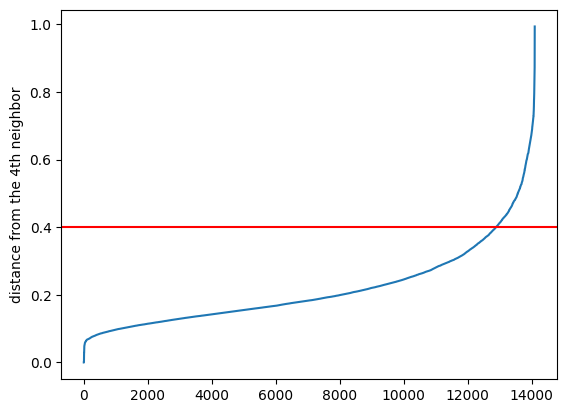

In [429]:
#Plot per la scelta di Eps
plt.plot(range(0, len(kth_distances_std)), sorted(kth_distances_std))
plt.ylabel('distance from the {}th neighbor'.format(k))
plt.axhline(y=0.4, color='r', linestyle='-')
         
plt.show()

In [430]:
#for loop per il calcolo di MinPts
nn_min=np.arange(2,51)
sil_list=[]
for i in nn_min:
    print(i)
    dbscan = DBSCAN(eps=0.4, min_samples=i, metric='precomputed')
    dbscan.fit(D_cat)
    sil_list.append(silhouette_score(D_cat,dbscan.labels_,metric='precomputed'))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


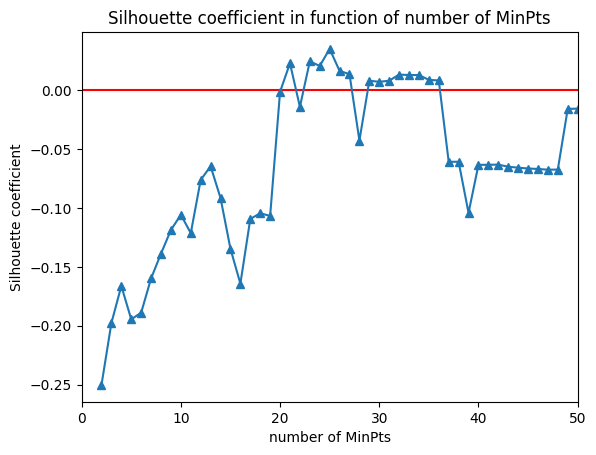

In [431]:
# plot per la scelta dei MinPts
plt.figure()
plt.title('Silhouette coefficient in function of number of MinPts')
plt.errorbar(nn_min, sil_list, marker='^')
plt.axhline(y=0., color='r', linestyle='-')
plt.ylabel('Silhouette coefficient')
plt.xlabel(r'number of MinPts')
plt.xlim(0,50)
plt.show()

In [462]:
#clustering con parametri tunati
dbscan = DBSCAN(eps=0.4, min_samples=20, metric='precomputed')
dbscan.fit(D_cat)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(D_cat,dbscan.labels_,metric='precomputed'))
plt.show()

labels {-1: 1976, 0: 11743, 1: 311, 2: 30, 3: 28, 4: 0}
silhouette -0.0022432729041960697
